## Housing Project: Advanced Regression Techniques

#### In this supervised learning project, I will employ feature engineering and various regression techniques in order to predict housing prices. 

#### First, I load the necessary libraries and examine the data:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skewtest
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import StackingRegressor

from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split


In [16]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [17]:
train_data.shape

(1460, 81)

In [18]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [19]:
test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## Step 1: Data cleaning

### 1.1: Checking for NaNs

#### A big part of data cleaning is dealing with NaN entries, and deciding whether/how to replace or remove them.

#### First, I create a function to check which columns contain NaN entries

In [20]:
def check_nans(data):
    """Checks data for NaN entries
    Inputs: Pandas Dataframe
    Outputs: Columns containing NaN entries"""
    
    nan_cols = []
    for col in data.columns:
        if data[col].isnull().values.any():
            nan_cols.append(col)
    return nan_cols

In [22]:
check_nans(train_data), check_nans(test_data)

(['LotFrontage',
  'Alley',
  'MasVnrType',
  'MasVnrArea',
  'BsmtQual',
  'BsmtCond',
  'BsmtExposure',
  'BsmtFinType1',
  'BsmtFinType2',
  'Electrical',
  'FireplaceQu',
  'GarageType',
  'GarageYrBlt',
  'GarageFinish',
  'GarageQual',
  'GarageCond',
  'PoolQC',
  'Fence',
  'MiscFeature'],
 ['MSZoning',
  'LotFrontage',
  'Alley',
  'Utilities',
  'Exterior1st',
  'Exterior2nd',
  'MasVnrType',
  'MasVnrArea',
  'BsmtQual',
  'BsmtCond',
  'BsmtExposure',
  'BsmtFinType1',
  'BsmtFinSF1',
  'BsmtFinType2',
  'BsmtFinSF2',
  'BsmtUnfSF',
  'TotalBsmtSF',
  'BsmtFullBath',
  'BsmtHalfBath',
  'KitchenQual',
  'Functional',
  'FireplaceQu',
  'GarageType',
  'GarageYrBlt',
  'GarageFinish',
  'GarageCars',
  'GarageArea',
  'GarageQual',
  'GarageCond',
  'PoolQC',
  'Fence',
  'MiscFeature',
  'SaleType'])

#### Here I create a function to display the data types of a list of columns in the dataset provided as an argument:

In [23]:
def check_data_types(data,col_list):
    for col in col_list:
        print(f"Column name: {col}, Data type: {data[col].dtype}")

#### I also separate the target variable from, the predictor variable, and then combine the train and test features for the purpose of cleaning the data

In [24]:
y_train = train_data['SalePrice']

In [26]:
train_data = train_data.drop('SalePrice',axis=1)

In [105]:
alldata = train_data.append(test_data)

In [106]:
check_data_types(alldata,check_nans(alldata))

Column name: MSZoning, Data type: object
Column name: LotFrontage, Data type: float64
Column name: Alley, Data type: object
Column name: Utilities, Data type: object
Column name: Exterior1st, Data type: object
Column name: Exterior2nd, Data type: object
Column name: MasVnrType, Data type: object
Column name: MasVnrArea, Data type: float64
Column name: BsmtQual, Data type: object
Column name: BsmtCond, Data type: object
Column name: BsmtExposure, Data type: object
Column name: BsmtFinType1, Data type: object
Column name: BsmtFinSF1, Data type: float64
Column name: BsmtFinType2, Data type: object
Column name: BsmtFinSF2, Data type: float64
Column name: BsmtUnfSF, Data type: float64
Column name: TotalBsmtSF, Data type: float64
Column name: Electrical, Data type: object
Column name: BsmtFullBath, Data type: float64
Column name: BsmtHalfBath, Data type: float64
Column name: KitchenQual, Data type: object
Column name: Functional, Data type: object
Column name: FireplaceQu, Data type: object


In [107]:
alldata = alldata.reset_index().iloc[:,1:]

#### Now, I go through every column in the data that contains NaNs. If the data is numeric, I can employ a skew test to determine whether the mean or median is better suited to replace the NaNs (the median is more suitable for skewed data).

#### For categorical data, the modal label will replace the missing entries.

#### This is quite a lengthy process, but it's important that the values we impute are those that are the least likely to misrepresent the data, and that we don't hastily discard columns that may provide valuable insight.

In [108]:
alldata['MSZoning'].value_counts(dropna=False)

RL         2265
RM          460
FV          139
RH           26
C (all)      25
NaN           4
Name: MSZoning, dtype: int64

In [109]:
mode = alldata['MSZoning'].value_counts().index[0]

alldata['MSZoning'] = alldata['MSZoning'].fillna(mode)

In [110]:
alldata['LotFrontage'].value_counts(dropna=False)

NaN      486
60.0     276
80.0     137
70.0     133
50.0     117
        ... 
138.0      1
31.0       1
144.0      1
141.0      1
28.0       1
Name: LotFrontage, Length: 129, dtype: int64

In [111]:
p = skewtest(alldata['LotFrontage'],nan_policy='omit')

if p[1] < 0.05:
    alldata['LotFrontage'] = alldata['LotFrontage'].fillna(alldata['LotFrontage'].median())
else:
    alldata['LotFrontage'] = alldata['LotFrontage'].fillna(alldata['LotFrontage'].mean())

In [112]:
alldata['Alley'].value_counts(dropna=False)

NaN     2721
Grvl     120
Pave      78
Name: Alley, dtype: int64

In [113]:
alldata['Alley'] = alldata['Alley'].fillna('None')

In [114]:
alldata['Utilities'].value_counts(dropna=False)

AllPub    2916
NaN          2
NoSeWa       1
Name: Utilities, dtype: int64

In [115]:
alldata['Utilities'] = alldata['Utilities'].fillna('AllPub')

In [116]:
alldata['Exterior1st'].value_counts(dropna=False)

VinylSd    1025
MetalSd     450
HdBoard     442
Wd Sdng     411
Plywood     221
CemntBd     126
BrkFace      87
WdShing      56
AsbShng      44
Stucco       43
BrkComm       6
AsphShn       2
CBlock        2
Stone         2
NaN           1
ImStucc       1
Name: Exterior1st, dtype: int64

In [117]:
alldata['Exterior1st'] = alldata['Exterior1st'].fillna('VinylSd')

In [118]:
alldata['Exterior2nd'].value_counts(dropna=False)

VinylSd    1014
MetalSd     447
HdBoard     406
Wd Sdng     391
Plywood     270
CmentBd     126
Wd Shng      81
Stucco       47
BrkFace      47
AsbShng      38
Brk Cmn      22
ImStucc      15
Stone         6
AsphShn       4
CBlock        3
Other         1
NaN           1
Name: Exterior2nd, dtype: int64

In [119]:
alldata['Exterior2nd'] = alldata['Exterior2nd'].fillna('VinylSd')

In [120]:
alldata['MasVnrType'].value_counts(dropna=False)

None       1742
BrkFace     879
Stone       249
BrkCmn       25
NaN          24
Name: MasVnrType, dtype: int64

In [121]:
alldata[['MasVnrType','MasVnrArea']][alldata[['MasVnrType','MasVnrArea']].isna().any(axis=1)]

,MasVnrType,MasVnrArea
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN
977,NaN,NaN
1243,NaN,NaN
1278,NaN,NaN
1691,NaN,NaN
1706,NaN,NaN


In [122]:
alldata.loc[2610,'MasVnrType'] = 'BrkFace'

In [123]:
alldata['MasVnrType'] = alldata['MasVnrType'].fillna('None')

In [124]:
alldata['MasVnrArea'].value_counts(dropna=False)

0.0       1738
NaN         23
120.0       15
200.0       13
176.0       13
          ... 
571.0        1
207.0        1
34.0         1
550.0        1
1159.0       1
Name: MasVnrArea, Length: 445, dtype: int64

In [125]:
alldata['MasVnrArea'] = alldata['MasVnrArea'].fillna(0.0)

In [126]:
alldata[['MasVnrType','MasVnrArea']][(alldata['MasVnrArea'] > 0) &  (alldata['MasVnrType'] == 'None')]

,MasVnrType,MasVnrArea
624,None,288.0
773,None,1.0
1230,None,1.0
1300,None,344.0
1334,None,312.0
1669,None,285.0
2452,None,1.0


In [127]:
for i in [624,773,1230,1300,1334,1669,2452]:
    alldata.loc[i,'MasVnrArea'] = 0.0

In [128]:
alldata[['MasVnrType','MasVnrArea']][(alldata['MasVnrArea'] == 0) &  (alldata['MasVnrType'] != 'None')]

,MasVnrType,MasVnrArea
688,BrkFace,0.0
1241,Stone,0.0
2319,BrkFace,0.0


In [129]:
for i in [688,1241,2319]:
    alldata.loc[i,'MasVnrType'] = 'None'

In [130]:
alldata['BsmtQual'].value_counts(dropna=False)

TA     1283
Gd     1209
Ex      258
Fa       88
NaN      81
Name: BsmtQual, dtype: int64

In [131]:
alldata['BsmtCond'].value_counts(dropna=False)

TA     2606
Gd      122
Fa      104
NaN      82
Po        5
Name: BsmtCond, dtype: int64

In [132]:
alldata['BsmtExposure'].value_counts(dropna=False)

No     1904
Av      418
Gd      276
Mn      239
NaN      82
Name: BsmtExposure, dtype: int64

In [133]:
alldata['BsmtFinType1'].value_counts(dropna=False)

Unf    851
GLQ    849
ALQ    429
Rec    288
BLQ    269
LwQ    154
NaN     79
Name: BsmtFinType1, dtype: int64

In [134]:
alldata['TotalBsmtSF'].value_counts(dropna=False)

0.0       78
864.0     74
672.0     29
912.0     26
1040.0    25
          ..
494.0      1
551.0      1
1154.0     1
105.0      1
1570.0     1
Name: TotalBsmtSF, Length: 1059, dtype: int64

In [135]:
alldata[['BsmtCond','TotalBsmtSF']][(alldata['BsmtCond'].isna()) & (alldata['TotalBsmtSF'] > 0)]

,BsmtCond,TotalBsmtSF
2040,NaN,1426.0
2185,NaN,1127.0
2524,NaN,995.0


In [136]:
for i in [2040,2185,2524]:
    alldata.loc[i,'BsmtCond'] = 'TA'

In [137]:
alldata[['BsmtExposure','TotalBsmtSF']][(alldata['BsmtExposure'].isna()) & (alldata['TotalBsmtSF'] > 0)]

,BsmtExposure,TotalBsmtSF
948,NaN,936.0
1487,NaN,1595.0
2348,NaN,725.0


In [138]:
for i in [948,1487,2348]:
    alldata.loc[i,'BsmtExposure'] = 'No'

In [139]:
alldata[['BsmtQual','TotalBsmtSF']][(alldata['BsmtQual'].isna()) & (alldata['TotalBsmtSF'] > 0)]

,BsmtQual,TotalBsmtSF
2217,NaN,173.0
2218,NaN,356.0


In [140]:
for i in [2217,2218]:
    alldata.loc[i,'BsmtQual'] = 'TA'

In [141]:
alldata['BsmtCond'] = alldata['BsmtCond'].fillna('None')
alldata['BsmtQual'] = alldata['BsmtQual'].fillna('None')
alldata['BsmtExposure'] = alldata['BsmtExposure'].fillna('None')
alldata['BsmtFinType1'] = alldata['BsmtFinType1'].fillna('None')


In [142]:
alldata['Electrical'].value_counts(dropna=False)

SBrkr    2671
FuseA     188
FuseF      50
FuseP       8
NaN         1
Mix         1
Name: Electrical, dtype: int64

In [143]:
alldata['Electrical'] = alldata['Electrical'].fillna('SBrkr')

In [144]:
alldata['BsmtFullBath'].value_counts(dropna=False)

0.0    1705
1.0    1172
2.0      38
NaN       2
3.0       2
Name: BsmtFullBath, dtype: int64

In [145]:
alldata['BsmtFullBath'] = alldata['BsmtFullBath'].fillna(0.0)

In [146]:
alldata['BsmtFinSF1'][alldata['BsmtFinSF1'].isna()]

2120   NaN
Name: BsmtFinSF1, dtype: float64

In [147]:
alldata.loc[2120,'BsmtFinSF1'] = 0
alldata.loc[2120,'BsmtFinSF2'] = 0
alldata.loc[2120,'TotalBsmtSF'] = 0
alldata.loc[2120,'BsmtUnfSF'] = 0


In [148]:
alldata[['TotalBsmtSF','BsmtFinType2']][alldata['BsmtFinType2'].isna() & (alldata['TotalBsmtSF'] > 0)]

,TotalBsmtSF,BsmtFinType2
332,3206.0,NaN


In [149]:
alldata.loc[332,'BsmtFinType2'] = 'Unf'

In [150]:
alldata['BsmtFinType2'] = alldata['BsmtFinType2'].fillna('None')

In [151]:
alldata['BsmtHalfBath'].value_counts(dropna=False)

0.0    2742
1.0     171
2.0       4
NaN       2
Name: BsmtHalfBath, dtype: int64

In [152]:
alldata['BsmtHalfBath'] = alldata['BsmtHalfBath'].fillna(0.0)

In [ ]:
all_features['BsmtFinSF1'][all_features['BsmtFinSF1'].isna()]

In [ ]:
all_features['BsmtFinSF2'][all_features['BsmtFinSF2'].isna()]

In [ ]:
all_features['TotalBsmtSF'][all_features['TotalBsmtSF'].isna()]

In [ ]:
all_features['BsmtUnfSF'][all_features['BsmtUnfSF'].isna()]

In [ ]:
all_features.loc[2120,'BsmtQual']

In [ ]:
all_features['BsmtFinType2'].value_counts(dropna=False)

In [ ]:
all_features[['TotalBsmtSF','BsmtFinType2']][all_features['BsmtFinType2'].isna() & (all_features['TotalBsmtSF'] > 0)]

In [ ]:
all_features.loc[332,'BsmtFinType2'] = 'Unf'

In [ ]:
all_features['BsmtFinType2'] = all_features['BsmtFinType2'].fillna('None')

In [ ]:
all_features.loc[2120,'BsmtFinSF1'] = 0
all_features.loc[2120,'BsmtFinSF2'] = 0
all_features.loc[2120,'TotalBsmtSF'] = 0
all_features.loc[2120,'BsmtUnfSF'] = 0

In [ ]:
all_features['BsmtHalfBath'].value_counts(dropna=False)

In [ ]:
all_features['BsmtHalfBath'] = all_features['BsmtHalfBath'].fillna('0.0')

In [ ]:
all_features['KitchenQual'].value_counts(dropna=False)

In [ ]:
all_features['KitchenQual'] = all_features['KitchenQual'].fillna('TA')

In [ ]:
all_features['Functional'].value_counts(dropna=False)

In [ ]:
all_features['Functional'] = all_features['Functional'].fillna('Typ')

In [ ]:
all_features['FireplaceQu'].value_counts(dropna=False)

In [ ]:
all_features['FireplaceQu'] = all_features['FireplaceQu'].fillna('None')

In [ ]:
all_features['GarageType'].value_counts(dropna=False)

In [ ]:
all_features['GarageYrBlt'].value_counts(dropna=False)

In [ ]:
all_features['GarageFinish'].value_counts(dropna=False)

In [ ]:
all_features['GarageCars'].value_counts(dropna=False)

In [ ]:
all_features['GarageQual'].value_counts(dropna=False)

In [ ]:
all_features['GarageCond'].value_counts(dropna=False)

In [ ]:
all_features[['GarageType','GarageFinish','GarageQual','GarageCond','GarageCars']][all_features['GarageCars'].isna()]

In [ ]:
all_features.loc[2576,'GarageFinish'] = 'Unf'
all_features.loc[2576,'GarageQual'] = 'TA'
all_features.loc[2576,'GarageCond'] = 'TA'
all_features.loc[2576,'GarageCars'] = 2.0

In [ ]:
all_features['GarageCars']

In [ ]:
all_features[['GarageType','GarageFinish','GarageQual','GarageCond','GarageCars']][(all_features['GarageCars'] > 0) & 
                                                                                   (all_features['GarageCond'].isna())]

In [ ]:
all_features.loc[2126,'GarageFinish'] = 'Unf'
all_features.loc[2126,'GarageQual'] = 'TA'
all_features.loc[2126,'GarageCond'] = 'TA'

In [ ]:
all_features['GarageFinish'] = all_features['GarageFinish'].fillna('None')
all_features['GarageQual'] = all_features['GarageQual'].fillna('None')
all_features['GarageCond'] = all_features['GarageCond'].fillna('None')
all_features['GarageType'] = all_features['GarageType'].fillna('None')

In [ ]:
all_features = all_features.drop('GarageYrBlt',axis=1)

In [ ]:
all_features['GarageArea'][all_features['GarageArea'].isna()]

In [ ]:
p = skewtest(all_features['GarageArea'],nan_policy='omit')

if p[1] < 0.05:
    all_features['GarageArea'] = all_features['GarageArea'].fillna(all_features['GarageArea'].median())
else:
    all_features['GarageArea'] = all_features['GarageArea'].fillna(all_features['GarageArea'].mean())

In [ ]:
all_features['PoolQC'].value_counts(dropna=False)

In [ ]:
all_features['PoolQC'] = all_features['PoolQC'].fillna('None')

In [ ]:
all_features['Fence'].value_counts(dropna=False)

In [ ]:
all_features['Fence'] = all_features['Fence'].fillna('None')

In [ ]:
all_features['MiscFeature'].value_counts(dropna=False)

In [ ]:
all_features['MiscFeature'] = all_features['MiscFeature'].fillna('None')

In [ ]:
all_features['SaleType'].value_counts(dropna=False)

In [ ]:
all_features['SaleType'] = all_features['SaleType'].fillna('WD')

#### Finally, I check for NaN features once again to make sure that they have all been dealt with, and save the cleaned data to a new .csv file

In [ ]:
check_data_types(all_features,check_nans(all_features))

In [ ]:
all_features.to_csv('all_features_no_nan.csv')

In [3]:
alldata = pd.read_csv('all_features_no_nan.csv',index_col=0)

In [4]:
alldata.shape

(2919, 79)

In [5]:
alldata.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,0,None,None,None,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,0,None,None,None,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,0,None,None,None,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,0,None,None,None,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,0,None,None,None,0,12,2008,WD,Normal


In [6]:
alldata['YrSold'].max(), alldata['YearBuilt'].max(), alldata['YearRemodAdd'].max()

(2010, 2010, 2010)

In [7]:
alldata['YrSold'] = 2010 - alldata['YrSold']
alldata['YearBuilt'] = 2010 - alldata['YearBuilt']
alldata['YearRemodAdd'] = 2010 - alldata['YearRemodAdd']

In [8]:
alldata['MSSubClass'].value_counts()

20     1079
60      575
50      287
120     182
30      139
70      128
160     128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64

In [9]:
alldata['MSSubClass'] = alldata['MSSubClass'].astype('str')

In [10]:
alldata['MoSold'] = alldata['MoSold'].astype('str')

In [11]:
alldata.to_csv('all_data_base.csv')

In [12]:
alldata = pd.read_csv('all_data_base.csv',index_col=0)

#### There are a couple of categorical features which are represented by integers and thus would be treated by an algorithm as continuous, so I'll convert them to str type

In [13]:
alldata['MSSubClass'] = alldata['MSSubClass'].astype('str')
alldata['MoSold'] = alldata['MoSold'].astype('str')

#### From here on I will be employing feature engineering to generate new features for the data, so I will separate the data at this point from the feature engineered data, in order to see which performs the best

In [14]:
basic_data = alldata.copy()

#### Here is the distribution of the target variable. It is visibly skewed, with a few extreme values to the right.

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

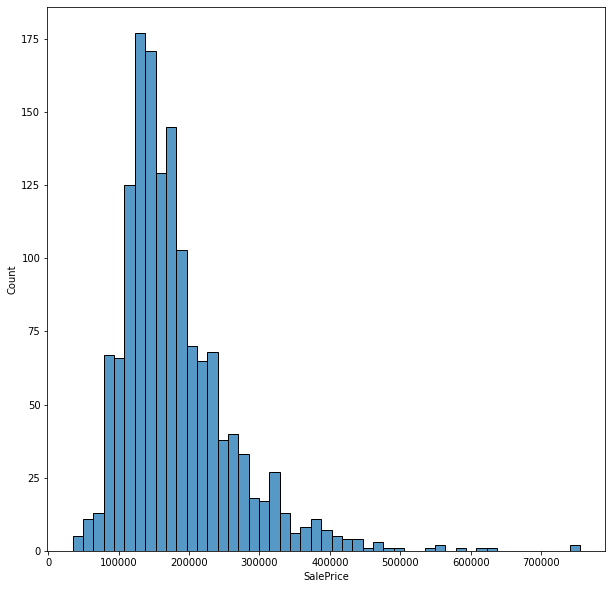

In [27]:
plt.figure(figsize=(10, 10))
sns.histplot(y_train)

#### Here is a helper function to plot a correlation heatmap between the numerical variables, which I'll use later.

In [28]:
def plot_correlation(xdata,ydata,ylabel):
    numeric_cols = [col for col in xdata.columns if (xdata[col].dtype == 'float64') or (xdata[col].dtype == 'int64')]
    data_numeric = xdata[numeric_cols]
    data_numeric[ylabel] = ydata
    sns.heatmap(data_numeric.corr(),cmap="YlGnBu")

#### A lot of categorical features have a clear numerical hierarchy, ie. they can be represented by ascending values with higher representing 'better', so I will convert these features.

In [29]:
alldata['LandSlope'] = alldata['LandSlope'].replace('Gtl',2)
alldata['LandSlope'] = alldata['LandSlope'].replace('Mod',1)
alldata['LandSlope'] = alldata['LandSlope'].replace('Sev',0)

alldata['ExterQual'] = alldata['ExterQual'].replace('Ex',5)
alldata['ExterQual'] = alldata['ExterQual'].replace('Gd',4)
alldata['ExterQual'] = alldata['ExterQual'].replace('TA',3)
alldata['ExterQual'] = alldata['ExterQual'].replace('Fa',2)
alldata['ExterQual'] = alldata['ExterQual'].replace('Po',1)

alldata['ExterCond'] = alldata['ExterCond'].replace('Ex',5)
alldata['ExterCond'] = alldata['ExterCond'].replace('Gd',4)
alldata['ExterCond'] = alldata['ExterCond'].replace('TA',3)
alldata['ExterCond'] = alldata['ExterCond'].replace('Fa',2)
alldata['ExterCond'] = alldata['ExterCond'].replace('Po',1)

alldata['Basement'] = alldata['BsmtQual'].apply(lambda x: 0 if x == 'None' else 1)
alldata['BsmtQual'] = alldata['BsmtQual'].replace('Ex',5)
alldata['BsmtQual'] = alldata['BsmtQual'].replace('Gd',4)
alldata['BsmtQual'] = alldata['BsmtQual'].replace('TA',3)
alldata['BsmtQual'] = alldata['BsmtQual'].replace('Fa',2)
alldata['BsmtQual'] = alldata['BsmtQual'].replace('None',0)

alldata['BsmtExposure'] = alldata['BsmtExposure'].replace('Gd',4)
alldata['BsmtExposure'] = alldata['BsmtExposure'].replace('Av',3)
alldata['BsmtExposure'] = alldata['BsmtExposure'].replace('Mn',2)
alldata['BsmtExposure'] = alldata['BsmtExposure'].replace('No',1)
alldata['BsmtExposure'] = alldata['BsmtExposure'].replace('None',0)

alldata['BsmtCond'] = alldata['BsmtCond'].replace('Ex',5)
alldata['BsmtCond'] = alldata['BsmtCond'].replace('Gd',4)
alldata['BsmtCond'] = alldata['BsmtCond'].replace('TA',3)
alldata['BsmtCond'] = alldata['BsmtCond'].replace('Fa',2)
alldata['BsmtCond'] = alldata['BsmtCond'].replace('Po',1)
alldata['BsmtCond'] = alldata['BsmtCond'].replace('None',0)

alldata['HeatingQC'] = alldata['HeatingQC'].replace('Ex',5)
alldata['HeatingQC'] = alldata['HeatingQC'].replace('Gd',4)
alldata['HeatingQC'] = alldata['HeatingQC'].replace('TA',3)
alldata['HeatingQC'] = alldata['HeatingQC'].replace('Fa',2)
alldata['HeatingQC'] = alldata['HeatingQC'].replace('Po',1)

alldata['KitchenQual'] = alldata['KitchenQual'].replace('Ex',5)
alldata['KitchenQual'] = alldata['KitchenQual'].replace('Gd',4)
alldata['KitchenQual'] = alldata['KitchenQual'].replace('TA',3)
alldata['KitchenQual'] = alldata['KitchenQual'].replace('Fa',2)
alldata['KitchenQual'] = alldata['KitchenQual'].replace('Po',1)

alldata['Functional'] = alldata['Functional'].replace('Typ',7)
alldata['Functional'] = alldata['Functional'].replace('Min1',6)
alldata['Functional'] = alldata['Functional'].replace('Min2',5)
alldata['Functional'] = alldata['Functional'].replace('Mod',4)
alldata['Functional'] = alldata['Functional'].replace('Maj1',3)
alldata['Functional'] = alldata['Functional'].replace('Maj2',2)
alldata['Functional'] = alldata['Functional'].replace('Sev',1)
alldata['Functional'] = alldata['Functional'].replace('Sal',0)

alldata['FireplaceQu'] = alldata['FireplaceQu'].replace('Ex',5)
alldata['FireplaceQu'] = alldata['FireplaceQu'].replace('Gd',4)
alldata['FireplaceQu'] = alldata['FireplaceQu'].replace('TA',3)
alldata['FireplaceQu'] = alldata['FireplaceQu'].replace('Fa',2)
alldata['FireplaceQu'] = alldata['FireplaceQu'].replace('Po',1)
alldata['FireplaceQu'] = alldata['FireplaceQu'].replace('None',0)

alldata['GarageFinish'] = alldata['GarageFinish'].replace('Fin',3)
alldata['GarageFinish'] = alldata['GarageFinish'].replace('RFn',2)
alldata['GarageFinish'] = alldata['GarageFinish'].replace('Unf',1)
alldata['GarageFinish'] = alldata['GarageFinish'].replace('None',0)

alldata['GarageQual'] = alldata['GarageQual'].replace('Ex',5)
alldata['GarageQual'] = alldata['GarageQual'].replace('Gd',4)
alldata['GarageQual'] = alldata['GarageQual'].replace('TA',3)
alldata['GarageQual'] = alldata['GarageQual'].replace('Fa',2)
alldata['GarageQual'] = alldata['GarageQual'].replace('Po',1)
alldata['GarageQual'] = alldata['GarageQual'].replace('None',0)

alldata['GarageCond'] = alldata['GarageCond'].replace('Ex',5)
alldata['GarageCond'] = alldata['GarageCond'].replace('Gd',4)
alldata['GarageCond'] = alldata['GarageCond'].replace('TA',3)
alldata['GarageCond'] = alldata['GarageCond'].replace('Fa',2)
alldata['GarageCond'] = alldata['GarageCond'].replace('Po',1)
alldata['GarageCond'] = alldata['GarageCond'].replace('None',0)



#### At this point, I save the data after one-hot encoding the categorical features, in the next steps I'll create some new features.

In [415]:
pd.get_dummies(alldata).to_csv('basic_dummies.csv')

#### Here is the heatmap of all the current features. Most aren't extremely highly correlated, but there are a few exceptions. The target variable seems most correlated with OverallQual and GrLivArea (the above ground square footage)

<ipython-input-413-6914a8e293c0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_numeric[ylabel] = ydata


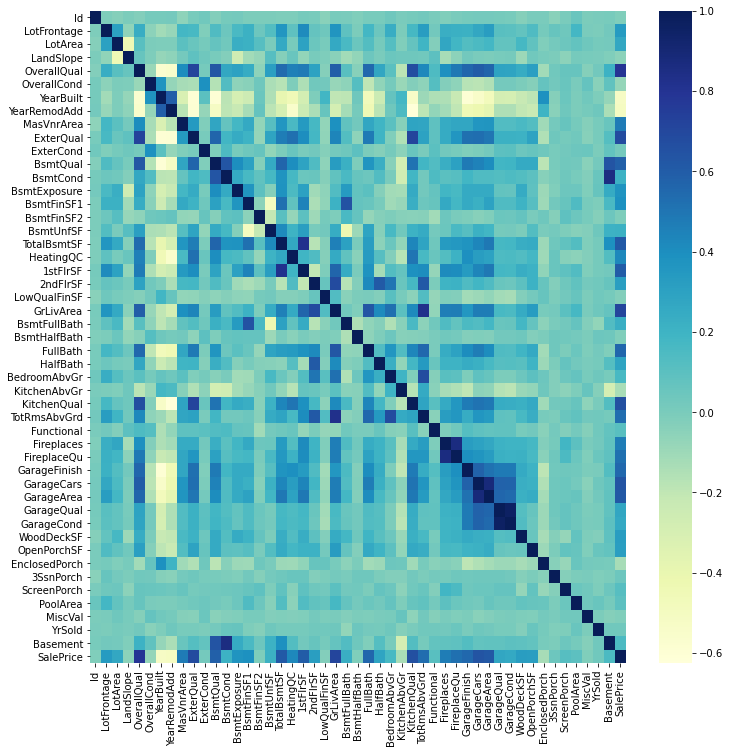

In [416]:
plt.figure(figsize=(12,12))
plot_correlation(alldata.iloc[:1460],y_train,"SalePrice")

#### Here, I create some strip plots of the most important predictor variables.

<AxesSubplot:xlabel='GarageCars', ylabel='SalePrice'>

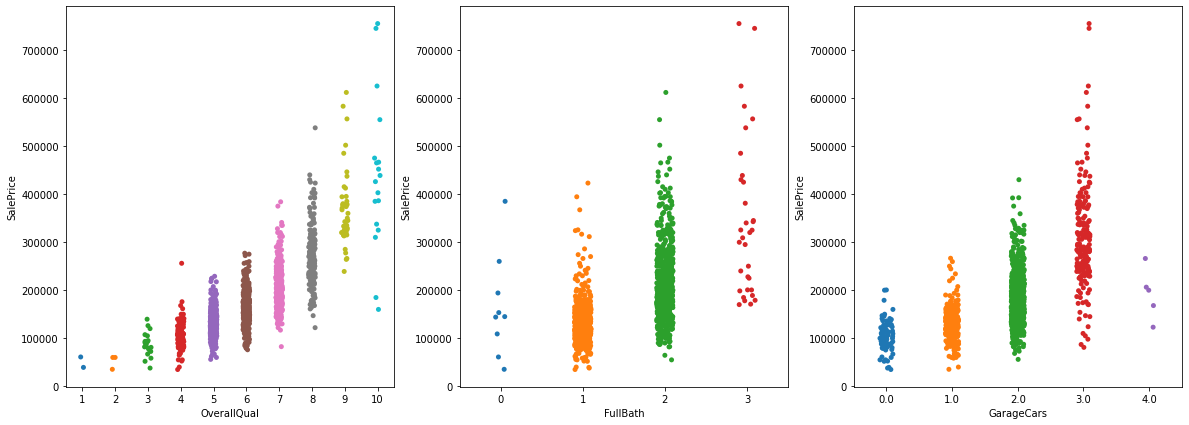

In [417]:
figure, ax = plt.subplots(1,3, figsize = (20,7))
sns.stripplot(x=alldata.loc[:1460,'OverallQual'],y=y_train,ax=ax[0])
sns.stripplot(x=alldata.loc[:1460,'FullBath'],y=y_train,ax=ax[1])
sns.stripplot(x=alldata.loc[:1460,'GarageCars'],y=y_train,ax=ax[2])

<AxesSubplot:xlabel='YrSold', ylabel='SalePrice'>

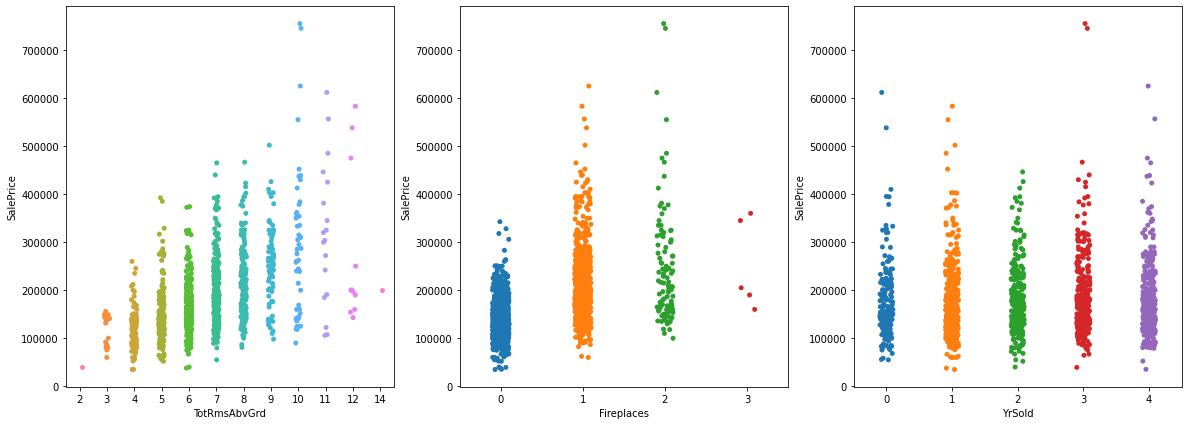

In [418]:
figure, ax = plt.subplots(1,3, figsize = (20,7))
sns.stripplot(x=alldata.loc[:1460,'TotRmsAbvGrd'],y=y_train,ax=ax[0])
sns.stripplot(x=alldata.loc[:1460,'Fireplaces'],y=y_train,ax=ax[1])
sns.stripplot(x=alldata.loc[:1460,'YrSold'],y=y_train,ax=ax[2])

#### Based on the plots, some values provide little to no new information, so I will combine them.

In [419]:
alldata['GarageCars'][alldata['GarageCars'] == 4] = 3
alldata['TotRmsAbvGrd'][alldata['TotRmsAbvGrd'] > 10] = 10
alldata['Fireplaces'][alldata['Fireplaces'] > 2] = 2


<ipython-input-419-98a878290ac8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alldata['GarageCars'][alldata['GarageCars'] == 4] = 3
<ipython-input-419-98a878290ac8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alldata['TotRmsAbvGrd'][alldata['TotRmsAbvGrd'] > 10] = 10
<ipython-input-419-98a878290ac8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alldata['Fireplaces'][alldata['Fireplaces'] > 2] = 2


In [420]:
def normalize(col):
    cmax = col.max()
    cmin = col.min()
    ccopy = col.copy()
    for i in range(len(col)):
        ccopy[i] = col[i] - cmin / (cmax - cmin)
    return ccopy

#### Here I engineer some new features from some of the more relevant features, both linear and nonlinear (multiplicative)

In [421]:
alldata['Qual_Cond'] = alldata['OverallQual'] + alldata['OverallCond']

alldata['TotalBath'] = alldata['FullBath'] + alldata['BsmtFullBath'] + 0.5*(alldata['HalfBath'] + alldata['BsmtHalfBath'])
alldata['Bath_Above'] = alldata['FullBath'] + 0.5*alldata['HalfBath']

alldata['Remodeled'] = alldata['YearBuilt'] - alldata['YearRemodAdd']
alldata['Remodeled'] = alldata['Remodeled'].apply(lambda x: 1 if x > 0 else 0)

alldata['TotalPorch'] = alldata['WoodDeckSF'] + alldata['OpenPorchSF'] + alldata['EnclosedPorch'] + alldata['3SsnPorch'] + alldata['ScreenPorch']

alldata['Age'] = alldata['YearBuilt'].apply(lambda x: np.floor((x+1)/10))
alldata['GarageQual_Cond'] = alldata['GarageQual'] + alldata['GarageCond']

alldata['Qual_SFT'] = alldata['OverallQual'] * alldata['GrLivArea']

alldata['Qual_Rooms'] = alldata['TotRmsAbvGrd'] * alldata['OverallQual']

#### I also drop some of the less valuable features whose relevance will be captured in the new features.

In [422]:
alldata = alldata.drop(['YearBuilt','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','Id'],axis=1)

#### Now I have two sets of data, the 'basic' features, and the data with the newly engineered features.

In [423]:
basic_dummies = pd.read_csv('basic_dummies.csv',index_col=0)
data_dummies = pd.get_dummies(alldata)

In [424]:
basic_dummies.head()

,Id,LotFrontage,LotArea,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,65.0,8450,2,7,5,7,7,196.0,4,...,0,0,0,1,0,0,0,0,1,0
1,2,80.0,9600,2,6,8,34,34,0.0,3,...,0,0,0,1,0,0,0,0,1,0
2,3,68.0,11250,2,7,5,9,8,162.0,4,...,0,0,0,1,0,0,0,0,1,0
3,4,60.0,9550,2,7,5,95,40,0.0,3,...,0,0,0,1,1,0,0,0,0,0
4,5,84.0,14260,2,8,5,10,10,350.0,4,...,0,0,0,1,0,0,0,0,1,0


In [425]:
data_dummies.head()

,LotFrontage,LotArea,LandSlope,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,2,7,5,7,196.0,4,3,4,...,0,0,0,1,0,0,0,0,1,0
1,80.0,9600,2,6,8,34,0.0,3,3,4,...,0,0,0,1,0,0,0,0,1,0
2,68.0,11250,2,7,5,8,162.0,4,3,4,...,0,0,0,1,0,0,0,0,1,0
3,60.0,9550,2,7,5,40,0.0,3,3,3,...,0,0,0,1,1,0,0,0,0,0
4,84.0,14260,2,8,5,10,350.0,4,3,4,...,0,0,0,1,0,0,0,0,1,0


#### I generate some more nonlinear features for the feature engineered data.

In [426]:
for col in data_dummies.columns:
    if 'Neighborhood' in col:
        print(col)
        newcol = col + '_' + 'OverallQual'
        data_dummies[newcol] = data_dummies[col] * data_dummies['OverallQual']
        
        newcol = col + '_' + 'Area'
        data_dummies[newcol] = data_dummies[col] * data_dummies['GrLivArea']
        
        newcol = col + '_' + 'LotArea'
        data_dummies[newcol] = data_dummies[col] * data_dummies['LotArea']
        
        newcol = col + '_' + 'Cars'
        data_dummies[newcol] = data_dummies[col] * data_dummies['GarageCars']
        
    if 'SaleCondition' in col:
        newcol = col + '_' + 'OverallQual'
        data_dummies[newcol] = data_dummies[col] * data_dummies['OverallQual']
        
        newcol = col + '_' + 'Area'
        data_dummies[newcol] = data_dummies[col] * data_dummies['GrLivArea']
        
        newcol = col + '_' + 'LotArea'
        data_dummies[newcol] = data_dummies[col] * data_dummies['LotArea']
        
        newcol = col + '_' + 'Cars'
        data_dummies[newcol] = data_dummies[col] * data_dummies['GarageCars']   
        
    if 'MSZoning' in col:
        newcol = col + '_' + 'OverallQual'
        data_dummies[newcol] = data_dummies[col] * data_dummies['OverallQual']
        
        newcol = col + '_' + 'Area'
        data_dummies[newcol] = data_dummies[col] * data_dummies['GrLivArea']
        
        newcol = col + '_' + 'LotArea'
        data_dummies[newcol] = data_dummies[col] * data_dummies['LotArea']
        
        newcol = col + '_' + 'Cars'
        data_dummies[newcol] = data_dummies[col] * data_dummies['GarageCars']
        
    if 'Foundation' in col:
        newcol = col + '_' + 'OverallQual'
        data_dummies[newcol] = data_dummies[col] * data_dummies['OverallQual']
        
        newcol = col + '_' + 'Area'
        data_dummies[newcol] = data_dummies[col] * data_dummies['GrLivArea']
        
        newcol = col + '_' + 'LotArea'
        data_dummies[newcol] = data_dummies[col] * data_dummies['LotArea']
        
        newcol = col + '_' + 'Cars'
        data_dummies[newcol] = data_dummies[col] * data_dummies['GarageCars']
        
    if col == 'Age':
        newcol = col + '_' + 'OverallQual'
        data_dummies[newcol] = data_dummies[col] * data_dummies['OverallQual']
        
        newcol = col + '_' + 'Area'
        data_dummies[newcol] = data_dummies[col] * data_dummies['GrLivArea']
        
        newcol = col + '_' + 'LotArea'
        data_dummies[newcol] = data_dummies[col] * data_dummies['LotArea']
        
        newcol = col + '_' + 'Cars'
        data_dummies[newcol] = data_dummies[col] * data_dummies['GarageCars']

Neighborhood_Blmngtn
Neighborhood_Blueste
Neighborhood_BrDale
Neighborhood_BrkSide
Neighborhood_ClearCr
Neighborhood_CollgCr
Neighborhood_Crawfor
Neighborhood_Edwards
Neighborhood_Gilbert
Neighborhood_IDOTRR
Neighborhood_MeadowV
Neighborhood_Mitchel
Neighborhood_NAmes
Neighborhood_NPkVill
Neighborhood_NWAmes
Neighborhood_NoRidge
Neighborhood_NridgHt
Neighborhood_OldTown
Neighborhood_SWISU
Neighborhood_Sawyer
Neighborhood_SawyerW
Neighborhood_Somerst
Neighborhood_StoneBr
Neighborhood_Timber
Neighborhood_Veenker


In [427]:
data_dummies.to_csv('data_dummies.csv')

In [3]:
data_dummies = pd.read_csv('data_dummies.csv',index_col=0)

In [4]:
data_dummies.shape

(2919, 451)

#### I can use a CatBoost regressor to observe the feature importances for my data:

In [10]:
scaler = MinMaxScaler()
basic_data_normal = pd.DataFrame(scaler.fit_transform(basic_dummies),columns=basic_dummies.columns)

In [11]:
cb = CatBoostRegressor(iterations=2000,max_depth=4,learning_rate=0.01,l2_leaf_reg=1)

In [ ]:
cb.fit(basic_data_normal.iloc[:1460],y_train)

In [16]:
def get_importance(model,data,train_num=1460):
    importance = model.get_feature_importance()
    
    importance_dict = {}
    for i in range(len(importance)):
        importance_dict[data.columns[i]] = importance[i]

    return sorted(importance_dict.items(),key=lambda x: x[1], reverse=True)

In [ ]:
importance = cb.get_feature_importance()

importance_list = zip(basic_data_normal.iloc[:1460].columns, importance)
for feature in sorted(importance_list, key = lambda t: t[1], reverse=True):
    print(feature)
    
basic_importance_dict = {}

for i in range(len(importance)):
    basic_importance_dict[basic_data_normal.iloc[:1460].columns[i]] = importance[i]

basic_importance_dict = sorted(basic_importance_dict.items(),key=lambda x: x[1], reverse=True)

#### This is consistent with the correlation heatmap, OverallQual and GrLivArea are the most important features. Features relating to the basement and the square footage are also notably important, as well as the number of bathrooms and garage car capacity.

In [18]:
basic_data.shape

(2919, 79)

#### Next, I need to establish extreme outliers in the training data. These points will throw off the model and performance will likely be superior if they're removed. I will apply the standard of removing any points with the absolute value of the studentized residual exceeding 3. However, I will also train on the data containing the outliers to show the comparison in performance.

In [19]:
basic_importance = get_importance(cb,basic_dummies)

In [20]:
basic_data_OLS = basic_data_normal[[x[0] for x in basic_importance][:25]]

In [21]:
OLS_model = sm.OLS(y_train,basic_data_OLS.iloc[:1460])
results = OLS_model.fit()

In [22]:
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:              SalePrice   R-squared (uncentered):                   0.969
Model:                            OLS   Adj. R-squared (uncentered):              0.968
Method:                 Least Squares   F-statistic:                              1784.
Date:                Mon, 08 Aug 2022   Prob (F-statistic):                        0.00
Time:                        13:00:58   Log-Likelihood:                         -17343.
No. Observations:                1460   AIC:                                  3.474e+04
Df Residuals:                    1435   BIC:                                  3.487e+04
Df Model:                          25                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [23]:
influence = OLSInfluence(results)
sresiduals = influence.resid_studentized_internal
print(sresiduals)

0      -0.290659
1      -0.138186
2      -0.315753
3      -1.525141
4      -1.132288
          ...   
1455   -0.058756
1456   -0.259029
1457    0.352675
1458    0.359516
1459    0.372494
Length: 1460, dtype: float64


#### Here are the studentized residuals exceeding 3

In [24]:
sresiduals[abs(sresiduals) > 3]

178      4.132995
185      4.022509
440      4.641632
473      3.596650
523     -9.774730
688      3.948837
691      8.091751
769      3.745586
774      3.165559
798      3.567767
803      6.344008
898      6.607279
1046     6.000367
1169     6.244045
1182     8.226154
1243     3.043053
1298   -16.118770
1324    -3.541805
dtype: float64

In [25]:
num_outliers = len(sresiduals[abs(sresiduals) > 3])

#### Here, I create a dictionary of datasets with three hyperparameters being varied:

#### 1. Whether the dataset contains the engineered features
#### 2. Whether the dataset contains the outlier points
#### 3. The number of features that the dataset retains (based on the CatBoost ranking)

In [468]:
dataset_dict = {}

dataset_dict['basic_dummies_max'] = basic_dummies
dataset_dict['basic_dummies_max_no_outliers'] = basic_dummies.drop(sresiduals[abs(sresiduals) > 3].index,axis=0)
dataset_dict['basic_dummies_200'] = basic_dummies[[x[0] for x in basic_importance][:200]]
dataset_dict['basic_dummies_200_no_outliers'] = basic_dummies[[x[0] for x in basic_importance][:200]].drop(sresiduals[abs(sresiduals) > 3].index,axis=0)
dataset_dict['basic_dummies_150'] = basic_dummies[[x[0] for x in basic_importance][:150]]
dataset_dict['basic_dummies_150_no_outliers'] = basic_dummies[[x[0] for x in basic_importance][:150]].drop(sresiduals[abs(sresiduals) > 3].index,axis=0)
dataset_dict['basic_dummies_100'] = basic_dummies[[x[0] for x in basic_importance][:100]]
dataset_dict['basic_dummies_100_no_outliers'] = basic_dummies[[x[0] for x in basic_importance][:100]].drop(sresiduals[abs(sresiduals) > 3].index,axis=0)

dataset_dict['data_dummies_max'] = data_dummies
dataset_dict['data_dummies_max_no_outliers'] = data_dummies.drop(sresiduals[abs(sresiduals) > 3].index,axis=0)
dataset_dict['data_dummies_200'] = data_dummies[[x[0] for x in importance][:200]]
dataset_dict['data_dummies_200_no_outliers'] = data_dummies[[x[0] for x in importance][:200]].drop(sresiduals[abs(sresiduals) > 3].index,axis=0)
dataset_dict['data_dummies_150'] = data_dummies[[x[0] for x in importance][:150]]
dataset_dict['data_dummies_150_no_outliers'] = basic_dummies[[x[0] for x in basic_importance][:150]].drop(sresiduals[abs(sresiduals) > 3].index,axis=0)
dataset_dict['data_dummies_100'] = data_dummies[[x[0] for x in importance][:100]]
dataset_dict['data_dummies_100_no_outliers'] = data_dummies[[x[0] for x in importance][:100]].drop(sresiduals[abs(sresiduals) > 3].index,axis=0)

In [469]:
for key,data in dataset_dict.items():
    print(f"Name: {key}, Shape: {data.shape}")

Name: basic_dummies_max, Shape: (2919, 277)
Name: basic_dummies_max_no_outliers, Shape: (2901, 277)
Name: basic_dummies_200, Shape: (2919, 200)
Name: basic_dummies_200_no_outliers, Shape: (2901, 200)
Name: basic_dummies_150, Shape: (2919, 150)
Name: basic_dummies_150_no_outliers, Shape: (2901, 150)
Name: basic_dummies_100, Shape: (2919, 100)
Name: basic_dummies_100_no_outliers, Shape: (2901, 100)
Name: data_dummies_max, Shape: (2919, 451)
Name: data_dummies_max_no_outliers, Shape: (2901, 451)
Name: data_dummies_200, Shape: (2919, 200)
Name: data_dummies_200_no_outliers, Shape: (2901, 200)
Name: data_dummies_150, Shape: (2919, 150)
Name: data_dummies_150_no_outliers, Shape: (2901, 150)
Name: data_dummies_100, Shape: (2919, 100)
Name: data_dummies_100_no_outliers, Shape: (2901, 100)


In [481]:
num_outliers

18

#### Here, I define a function to split each dataset in the dictionary into training and validation:

In [496]:
def train_validation_split(name,xdata,p=0.3):
    outliers=0
    ydata = y_train
    if 'outliers' in name:
        print('hi')
        xdata = xdata.reset_index().iloc[:,1:]
        ydata = y_train.drop(sresiduals[abs(sresiduals) > 3].index,axis=0).reset_index().iloc[:,1:]
        outliers = num_outliers
    return train_test_split(xdata.iloc[:(1460-outliers)],ydata,test_size=p,random_state=42)

#### I construct a relatively simple CatBoost model as a preliminary means of observing the performance of each dataset, and fit the model to each dataset.

In [493]:
preliminary_model = CatBoostRegressor(iterations=5000,max_depth=4,learning_rate=0.01,l2_leaf_reg=3,verbose=0,od_wait=200)

In [494]:
for key,data in dataset_dict.items():
    Xt,Xv,yt,yv = train_validation_split(key,data)
    preliminary_model.fit(Xt,yt,eval_set=(Xv,yv))
    print(f"Name: {key}, Result: {np.sqrt(mean_squared_error(yv,preliminary_model.predict(Xv)))}")

Name: basic_dummies_max, Result: 22381.49670380449
hi
Name: basic_dummies_max_no_outliers, Result: 18089.674213071667
Name: basic_dummies_200, Result: 22978.15437440461
hi
Name: basic_dummies_200_no_outliers, Result: 16847.68249003425
Name: basic_dummies_150, Result: 21877.968100814087
hi
Name: basic_dummies_150_no_outliers, Result: 17419.042646350037
Name: basic_dummies_100, Result: 27685.27476513819
hi
Name: basic_dummies_100_no_outliers, Result: 19668.454866820444
Name: data_dummies_max, Result: 26743.0965591727
hi
Name: data_dummies_max_no_outliers, Result: 19436.03328368384
Name: data_dummies_200, Result: 22862.584693612316
hi
Name: data_dummies_200_no_outliers, Result: 19427.51935354612
Name: data_dummies_150, Result: 21927.81064878785
hi
Name: data_dummies_150_no_outliers, Result: 19662.676970742847
Name: data_dummies_100, Result: 24454.382588485216
hi
Name: data_dummies_100_no_outliers, Result: 18727.24894816585


#### It can be instantly concluded that the model performs far better on the data with outliers removed in all cases, so I will remove all the datasets containing the outliers from the dict.

In [495]:
for x in ['basic_dummies_max','basic_dummies_200','basic_dummies_150','basic_dummies_100','data_dummies_max',
         'data_dummies_200','data_dummies_150','data_dummies_100']:
    del dataset_dict[x]

#### I define a larger model to train again on the remaining datasets

In [497]:
second_model = CatBoostRegressor(iterations=10000,max_depth=4,learning_rate=0.005,l2_leaf_reg=3,verbose=0,od_wait=200,random_state=42)

In [498]:
for key,data in dataset_dict.items():
    Xt,Xv,yt,yv = train_validation_split(key,data)
    second_model.fit(Xt,yt,eval_set=(Xv,yv))
    print(f"Name: {key}, Result: {np.sqrt(mean_squared_error(yv,second_model.predict(Xv)))}")

hi
Name: basic_dummies_max_no_outliers, Result: 16760.125864429698
hi
Name: basic_dummies_200_no_outliers, Result: 16642.940189624096
hi
Name: basic_dummies_150_no_outliers, Result: 16635.8735336892
hi
Name: basic_dummies_100_no_outliers, Result: 16577.979421729477
hi
Name: data_dummies_max_no_outliers, Result: 16981.93995986067
hi
Name: data_dummies_200_no_outliers, Result: 16821.103710667852
hi
Name: data_dummies_150_no_outliers, Result: 16635.8735336892
hi
Name: data_dummies_100_no_outliers, Result: 16398.431388519366


#### The difference in performance isn't significant between the models, but I will choose the best-performing one, which is the dataset with engineered features limited to the best 100 features.

In [500]:
selected_data = dataset_dict['data_dummies_100_no_outliers']

#### I will now try a few different model architectures on the selected dataset, starting with RandomForest.

#### I create a parameter grid and use GridCV to test the model with all different parameter combinations.

In [508]:
rf = RandomForestRegressor(random_state=42)

In [507]:
rf_params = {
    'n_estimators': [1000,2000,5000],
    'max_depth': [3,5,7],
}

In [526]:
rf_params2 = {
    'n_estimators': [5000],
    'max_depth': [16],
}

In [527]:
rf_cv = GridSearchCV(rf,param_grid=rf_params2,cv=4,verbose=2,refit=True,scoring='neg_root_mean_squared_error')

In [528]:
Xt = selected_data[:1460-num_outliers].reset_index().iloc[:,1:]
yt = y_train.drop(sresiduals[abs(sresiduals) > 3].index,axis=0).reset_index().iloc[:,1:]

In [570]:
Xtest = selected_data[1460-num_outliers:]

In [529]:
rf_cv.fit(Xt,yt)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


C:\Users\nickj\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....................max_depth=16, n_estimators=5000; total time= 1.4min


C:\Users\nickj\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....................max_depth=16, n_estimators=5000; total time= 1.4min


C:\Users\nickj\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....................max_depth=16, n_estimators=5000; total time= 1.4min


C:\Users\nickj\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END ....................max_depth=16, n_estimators=5000; total time= 1.4min


C:\Users\nickj\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=4, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [16], 'n_estimators': [5000]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [530]:
rf_cv.cv_results_['mean_test_score']

array([-22282.81378228])

#### The random forest doesn't perform nearly as well as the initial CatBoost regressor.

In [525]:
rf_cv.best_params_

{'max_depth': 16, 'n_estimators': 2000}

#### Next, I will try XGBoost

In [537]:
xgb_params = {
    'max_depth': [3,5,7],
    'learning_rate': [0.01,0.025,0.05],
    'min_child_weight': [1,2]
}

In [540]:
xgb = XGBRegressor(n_estimators=10000,random_state=42)

In [541]:
xgb_cv = GridSearchCV(xgb,param_grid=xgb_params,cv=4,verbose=2,refit=True,scoring='neg_root_mean_squared_error')

In [542]:
xgb_cv.fit(Xt,yt)

Fitting 4 folds for each of 18 candidates, totalling 72 fits
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1; total time=  14.5s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1; total time=  23.7s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1; total time=  21.1s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1; total time=  23.0s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=2; total time=  19.7s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=2; total time=  19.9s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=2; total time=  19.0s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=2; total time=  19.1s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=1; total time=  31.3s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=1; total time=  34.9s
[CV] END learning_rate=0.01, max_depth=5, min_child_weight=1; total time=  31.9s
[CV] END learning_rate=0.01, max_depth=5, min_ch

GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.02, max_delta_step=None,
                                    max_depth=5, min_child_weight=2,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=10000, n_jobs=None,
                                    num_parallel_tree=None, random_state=42,
                                    reg_alpha=100, reg_lambda=1,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
                                    verbosity=None),
             param_grid={'learning_rate': [0.01, 0.025, 0.05],
                         'max_depth': [3, 5, 7], 'min_child_weight': [1, 2]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [543]:
xgb_cv.cv_results_['mean_test_score']

array([-19244.30269429, -19106.19710736, -20539.42491193, -20318.83175196,
       -21418.25055293, -20916.68032895, -19247.91581876, -19338.8315725 ,
       -20493.25745995, -20268.90223058, -21322.22356029, -20870.32400986,
       -19412.48419019, -19080.27711073, -20393.29712386, -20350.12064422,
       -21471.87134242, -21088.46912331])

#### I use the best parameters found from the grid search, and apply the model with early stopping:

In [544]:
xgb_cv.best_params_

{'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 2}

In [545]:
xgb_selected = XGBRegressor(n_estimators=20000,learning_rate=0.05,max_depth=3,min_child_weight=2,random_state=42)

In [550]:
X,Xv,y,yv = train_test_split(Xt,yt,test_size=0.25,random_state=42)

In [551]:
y.shape

(1081, 1)

In [ ]:
xgb_selected.fit(X, y, eval_set=[(X, y), (Xv, yv)], early_stopping_rounds=200) 

#### Validation score is around 17,000, which is a good score but not as low as CatBoost

#### Now I perform grid search using the CatBoost regressor:

In [554]:
cb = CatBoostRegressor(verbose=0,random_state=42)

In [555]:
cb_params = {
    'iterations': [5000,10000],
    'max_depth': [3,4,5],
    'learning_rate': [0.005,0.01,0.025],
    'l2_leaf_reg': [1,3]
}

In [558]:
cb_cv = GridSearchCV(cb,param_grid=cb_params,cv=4,verbose=2,refit=True,scoring='neg_root_mean_squared_error')

In [ ]:
cb_cv.fit(Xt,yt)

In [560]:
cb_cv.cv_results_['mean_test_score']

array([-18270.77378971, -18116.69007404, -18138.91362021, -18066.70719205,
       -18030.80491818, -18171.63735918, -18319.64978081, -18132.19054064,
       -18311.98920678, -18472.07020713, -18252.50041197, -18207.01950656,
       -18166.33729826, -18156.45127519, -18083.78402668, -18262.05653048,
       -18291.44977362, -18296.54223249, -18070.62939298, -18053.11755852,
       -18109.81504983, -18168.95066476, -18115.69405783, -18231.94287808,
       -18466.88447944, -18194.39180761, -18341.34123634, -18105.74976306,
       -18131.09789362, -18135.41851174, -18213.93886082, -18241.52416135,
       -18155.16184412, -18392.83451298, -18395.14600339, -18337.85666651])

#### I identify the best parameters and train a model with them using early stopping. This provides the best RMSE so far.

In [561]:
cb_cv.best_params_

{'iterations': 5000, 'l2_leaf_reg': 1, 'learning_rate': 0.01, 'max_depth': 4}

In [563]:
cb_selected = CatBoostRegressor(iterations=20000,learning_rate=0.01,max_depth=4,l2_leaf_reg=1,random_state=42,od_wait=250)

In [ ]:
cb_selected.fit(X, y, eval_set=(Xv, yv))

#### Test set evaluation is on Kaggle, and uses RMSLE as the metric. CatBoostRegressor doesn't have native support for RMSLE as an evaluation metric, so I write a class that is compatible with CatBoost:

In [562]:
class CatBoostEvalMetricRMSLE(object):
    def get_final_error(self, error, weight):
        return error

    def is_max_optimal(self):
        # the larger metric value the better
        return False

    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])
        preds = np.array(approxes[0])
        target = np.array(target)
        score = np.sqrt(mean_squared_log_error(target,preds))
        return score, 0

In [566]:
cb_selected_RMSLE = CatBoostRegressor(iterations=20000,learning_rate=0.01,max_depth=4,l2_leaf_reg=1,random_state=42,
                                     eval_metric=CatBoostEvalMetricRMSLE(),od_wait=250)

In [ ]:
cb_selected_RMSLE.fit(X, y, eval_set=(Xv, yv))

#### I train the final model with the suggested number of iterations on the entire training set:

In [568]:
cb_final = CatBoostRegressor(iterations=4500,learning_rate=0.01,max_depth=4,l2_leaf_reg=1,random_state=42)

In [ ]:
cb_final.fit(Xt,yt)

In [571]:
predictions = cb_final.predict(Xtest)

In [572]:
predictions_series = pd.Series(predictions,index=test_data.Id,name='SalePrice')

In [573]:
predictions_series.to_csv('predictions_cb.csv')

#### Finally, I arrive at the predictions for the test set, and sav them to a .csv.

In [574]:
predictions_series.head()

Id
1461    120775.387036
1462    164292.758716
1463    181141.063972
1464    191234.660963
1465    184955.693724
Name: SalePrice, dtype: float64

#### These predictions resulted in a test RMSLE of approximately 0.126, which is a fairly good performance, though disappointingly higher than the validation RMSLE. However, the training set and the test set have the same amount of data, so it's probably to be expected that test performance won't be as high as validation.